In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt
import xgcm

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
ds = open_s3fs('PC-data')
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [4]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://velocity-u.zarr/'
data_path2 = 's3://velocity-v.zarr/'
remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
du = xr.open_zarr(store=store1, consolidated=True)
du = du.rename({'depthu' : 'depth'})
dv = xr.open_zarr(store=store2, consolidated=True)
dv = dv.rename({'depthv' : 'depth'})
  

In [5]:
d = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))
lat = ds.nav_lat.isel(y=slice(900,1800), x=slice(200,1400))
lon = ds.nav_lon.isel(y=slice(900,1800), x=slice(200,1400))

Length in meters of 1° of latitude = always 111.32 km

Length in meters of 1° of longitude = 40075 km * cos( latitude ) / 360

In [8]:
lat_m = lat*111.32*10**3
lon_m = (40075*10**3*np.cos(np.deg2rad(lat)))/360

In [9]:
lon_m.values

array([[45882.39860824, 45847.69674266, 45812.93847826, ...,
        46161.22776642, 46214.73034637, 46268.22960873],
       [45844.93651779, 45810.1915237 , 45775.37022531, ...,
        46116.91819504, 46170.50371443, 46224.08591625],
       [45807.56731952, 45772.76924418, 45737.91808759, ...,
        46072.7214213 , 46126.36333952, 46180.01852805],
       ...,
       [55257.67821819, 55234.07365092, 55210.44254303, ...,
        56738.15402306, 56775.64265413, 56813.15782583],
       [55309.20020408, 55285.63544775, 55262.05742111, ...,
        56793.49785878, 56830.90686798, 56868.34241781],
       [55360.76200091, 55337.26359614, 55313.74860348, ...,
        56848.86823512, 56886.1909873 , 56923.54691525]])

In [10]:
warnings.simplefilter("ignore")

hb_lon = np.zeros((900,1200))
hb_lat = np.zeros((900,1200))

for i, val in enumerate(lon_m[:,0]):    
    hb_lon[i,:] = np.gradient(d[i,:],lon_m[i,:],axis=0)

for i, val in enumerate(lat_m[0,:]):    
    hb_lat[:,i] = np.gradient(d[:,i],lat_m[:,i],axis=0)

In [42]:
np.isnan(hb_lon).any()

True

In [45]:
np.isnan(hb_lon).any()

True

 ...]

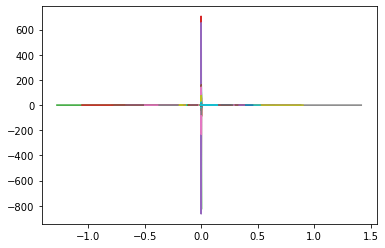

In [43]:
np.isnan(hb_lat).any()

True

In [34]:
v = dv.vomecrty.isel(y=slice(900,1800), x=slice(200,1400)) #.mean(dim='time_counter')
u = du.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400)) #.mean(dim='time_counter')

In [37]:
time = np.arange(73)
level = np.arange(75)

u_ort = np.zeros((900,1200,75,73))
v_ort = np.zeros((900,1200,75,73))

for l in level:
    for t in time:
        print('level: ',l,'time: ',t)
        u_ort[:,:,l,t] = u.isel(time_counter=t, depth=l)*hb_lon
        v_ort[:,:,l,t] = v.isel(time_counter=t, depth=l)*hb_lat

level:  0 time:  0
level:  0 time:  1
level:  0 time:  2
level:  0 time:  3
level:  0 time:  4
level:  0 time:  5
level:  0 time:  6
level:  0 time:  7
level:  0 time:  8
level:  0 time:  9
level:  0 time:  10
level:  0 time:  11
level:  0 time:  12
level:  0 time:  13
level:  0 time:  14
level:  0 time:  15
level:  0 time:  16
level:  0 time:  17
level:  0 time:  18
level:  0 time:  19
level:  0 time:  20
level:  0 time:  21
level:  0 time:  22
level:  0 time:  23
level:  0 time:  24
level:  0 time:  25
level:  0 time:  26
level:  0 time:  27
level:  0 time:  28
level:  0 time:  29
level:  0 time:  30
level:  0 time:  31
level:  0 time:  32
level:  0 time:  33
level:  0 time:  34
level:  0 time:  35
level:  0 time:  36
level:  0 time:  37
level:  0 time:  38
level:  0 time:  39
level:  0 time:  40
level:  0 time:  41
level:  0 time:  42
level:  0 time:  43


KeyboardInterrupt: 

In [40]:
u_ort

array([[[[nan, nan, nan, ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        ...,

        [[nan, nan, nan, ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.

In [53]:
h_lat = xr.DataArray(hb_lat, dims = ['y','x'])
h_lon = xr.DataArray(hb_lon, dims = ['y','x'])

grad_hb = xr.merge([h_lat.to_dataset(name='lat')
                    ,h_lon.to_dataset(name='lon')])

In [56]:
grad_hb

<xarray.Dataset>
Dimensions:  (x: 1200, y: 900)
Dimensions without coordinates: x, y
Data variables:
    lat      (y, x) object 0.0 0.0 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0 -0.0 -0.0
    lon      (y, x) object -0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

## CREG12.L75-REF08_mesh_hgr.nc

includes all horizontal metrics for each grid points as well. 
for instance  for the scalars such as temperature and salinity, T-point, the scale factors to use are e1t (zonal) e2t (meridional).
They are invariant over the depth


In [62]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })

fsg.ls('s3://data')
data_path = f's3://data/CREG12.L75-REF08_mesh_hgr.nc'
remote_files = fsg.glob(data_path)
fileset = [fsg.open(file) for file in remote_files]
dm = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
dm

<xarray.Dataset>
Dimensions:       (t: 1, x: 1580, y: 1801, z: 75)
Dimensions without coordinates: t, x, y, z
Data variables: (12/21)
    nav_lon       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(75,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    ...            ...
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 1801, 1580), meta=np.ndarray>
Attributes:
    file_name:  mesh_hgr.nc
    TimeStamp:  06/06/2019 11:25:45 +0200